In [1]:
# Copia do horario mas aqui o estudo e feito para prever a soma dia seguinte
import pandas as pd
import matplotlib.pyplot as plt


import os



In [2]:
dataset_file_path = "/home/joao/Documents/repos/renewable-generation-into-reserve-markets/data/DynamicSecondary.csv"

In [3]:
dataset = pd.read_csv(dataset_file_path, index_col=0)

In [4]:
dataset

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
0              83.7       116.9                   3715.0             0.0   
1              11.6       348.1                   3748.0             0.0   
2              15.3       286.9                   3545.0             0.0   
3              36.6       398.4                   3407.0             0.0   
4              22.4       280.9                   3321.0             0.0   
...             ...         ...                      ...             ...   
35058          35.0       673.5                  10477.8             0.0   
35059          21.1       344.9                  10446.8             0.0   
35060         486.0         3.9                  10402.5             0.0   
35061         352.4        15.9                  10305.0             0.0   
35062           NaN         NaN                      NaN             NaN   

       DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
0                  21808.0           18365.7                1524.9   
1                  20635.0           17396.3                1336.4   
2                  19824.0           17080.8                1158.3   
3                  19544.0           17125.4                1114.3   
4                  19803.0           17163.7                1323.6   
...                    ...               ...                   ...   
35058              25256.5           24128.0                 483.6   
35059              24142.3           20040.7                3398.3   
35060              21761.5           19618.6                1756.2   
35061              20590.3           16847.4                3270.8   
35062                  NaN               NaN                   NaN   

       DA Traded Wind  DA Traded PV  
0              4326.8           7.1  
1              4213.9           7.1  
2              4059.7           7.1  
3              3921.6           7.1  
4              3902.3          14.1  
...               ...           ...  
35058         11457.4           8.6  
35059          9346.3           7.2  
35060          9190.6           6.7  
35061          8314.2           6.6  
35062          6612.5           2.0  

[35063 rows x 9 columns]

In [5]:
# Simply remove NAN 
dataset = dataset.dropna(how='any')



/home/joao/.virtualenvs/tese/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


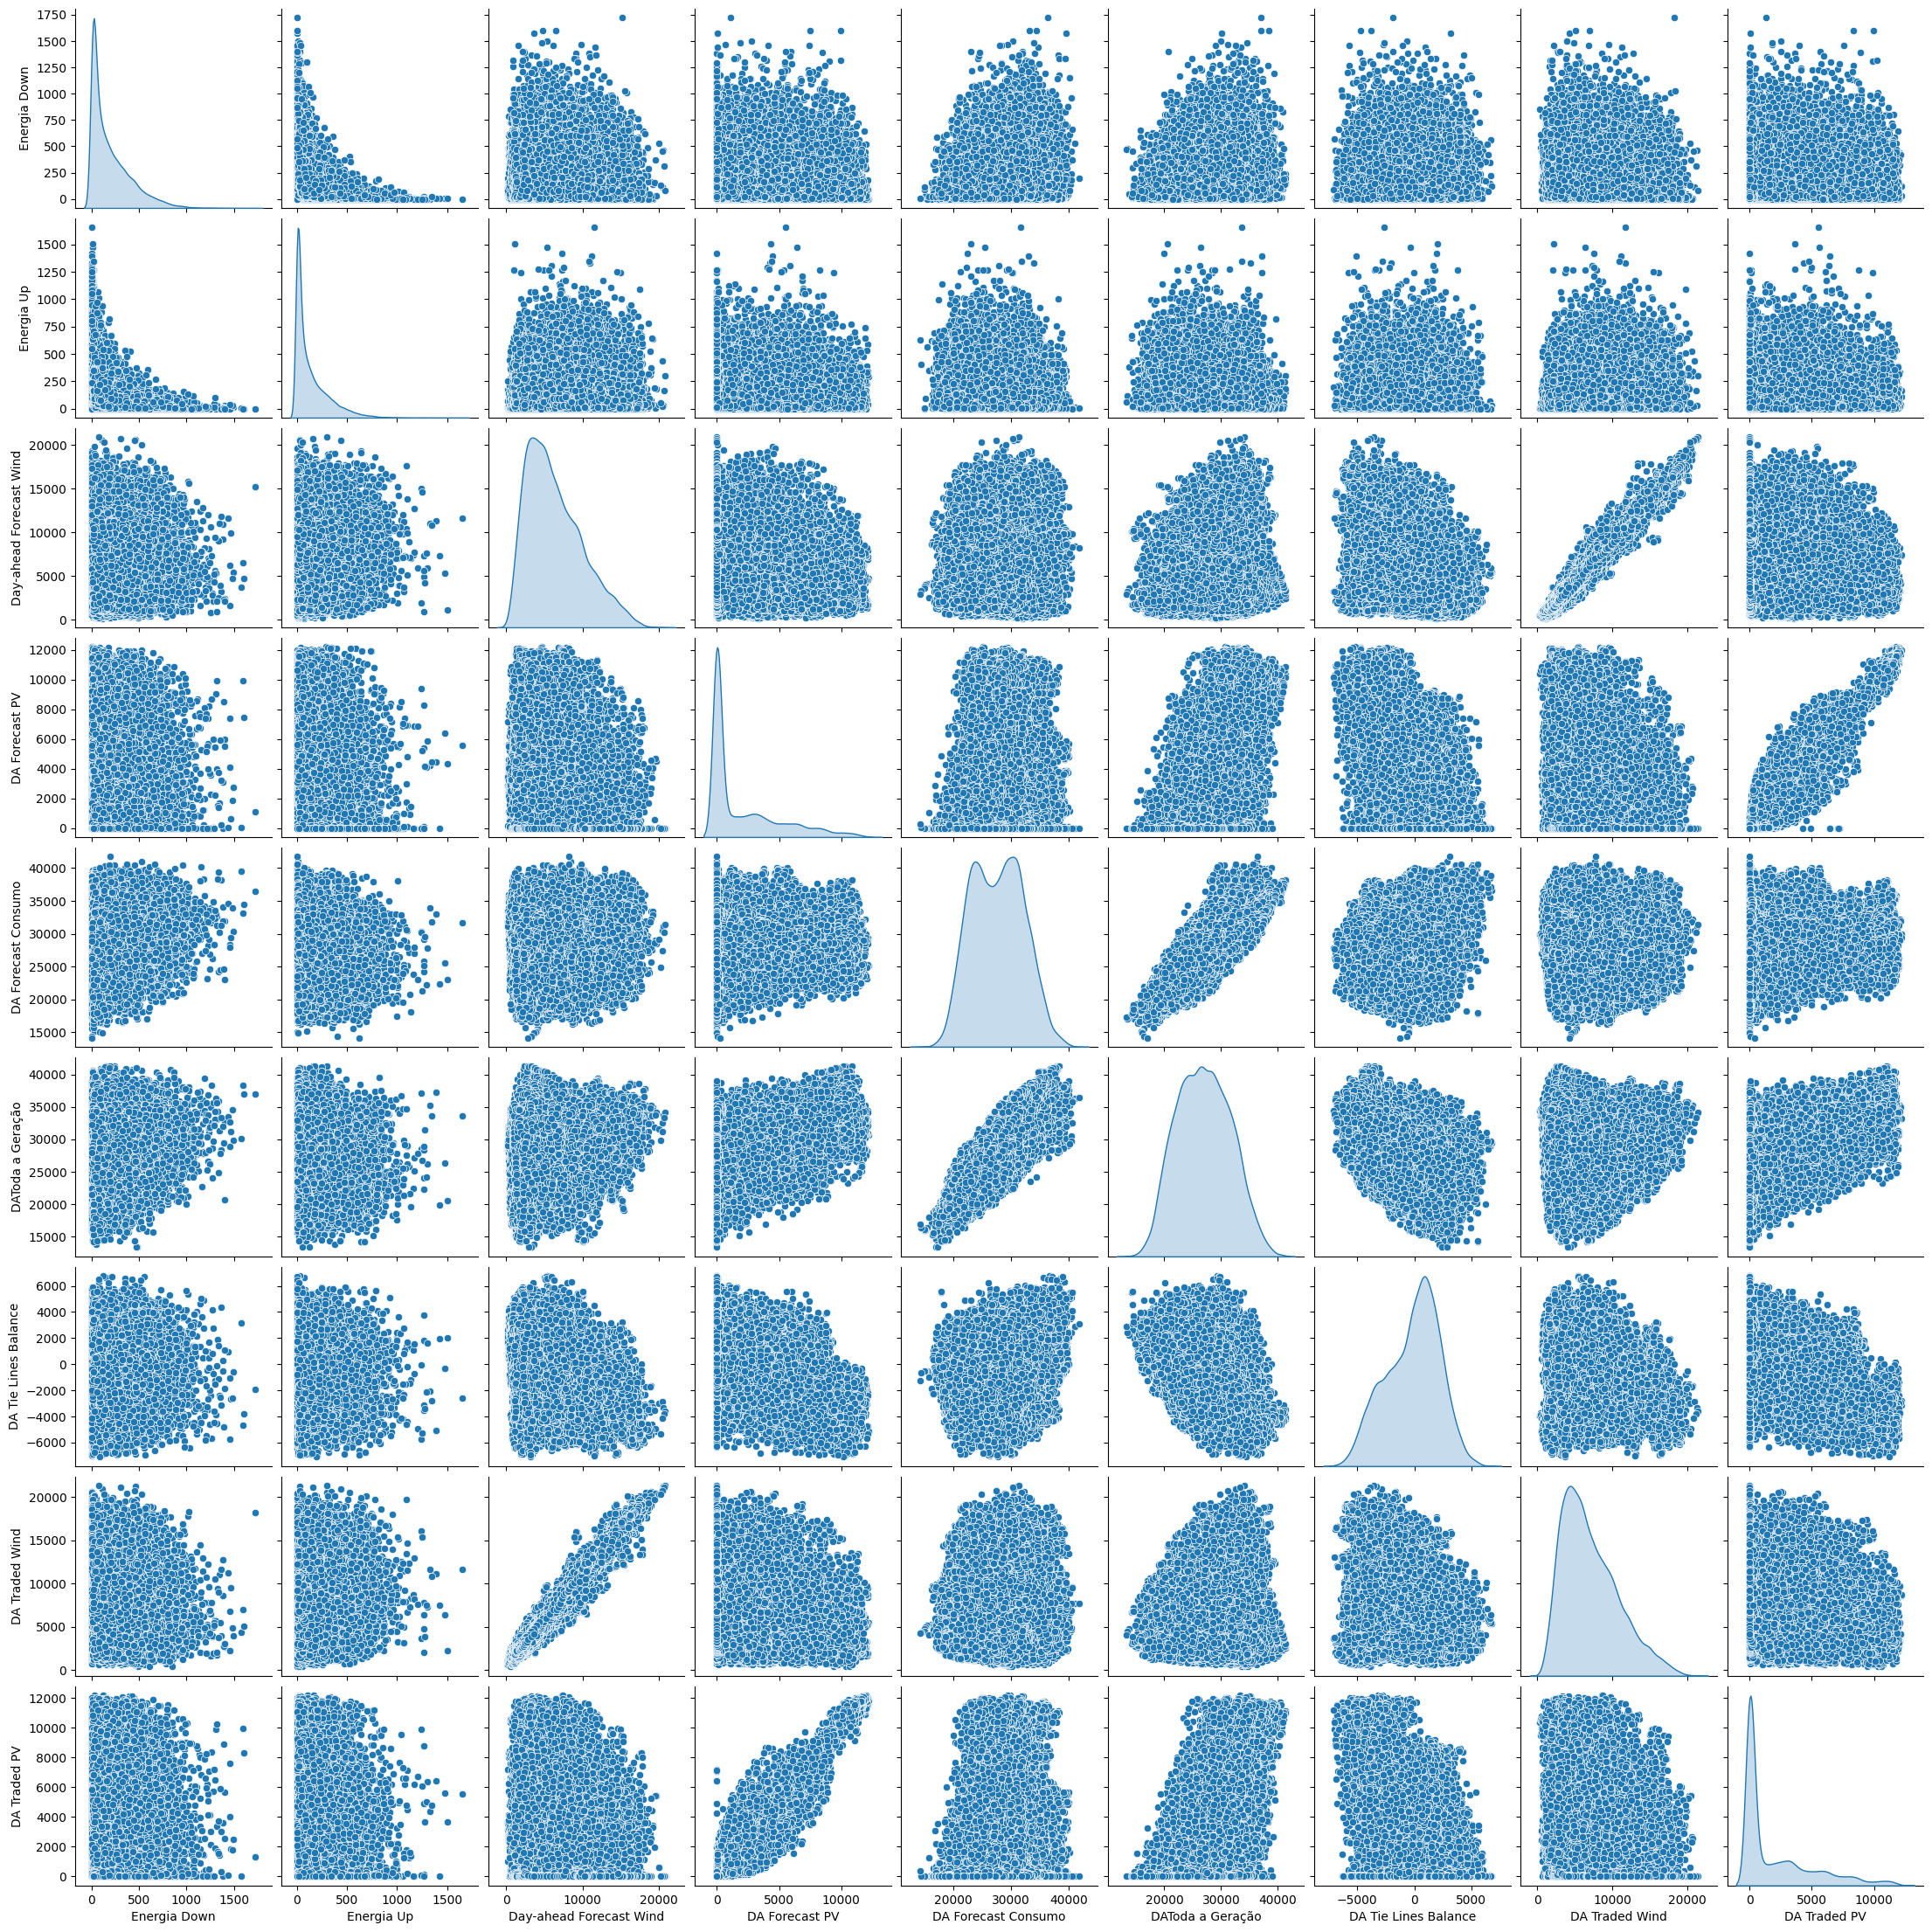

In [6]:
import seaborn as sns

columns_Y = ["Energia Down", "Energia Up"]
columns_X = dataset.columns[~dataset.columns.isin(columns_Y)] 
sns.pairplot(dataset, diag_kind='kde')


In [7]:
dataset.describe().transpose()


count          mean          std      min  \
Energia Down             35062.0    199.737111   212.105286      0.0   
Energia Up               35062.0    137.395391   170.934599      0.0   
Day-ahead Forecast Wind  35062.0   6374.223966  3649.760395    139.0   
DA Forecast PV           35062.0   2051.058096  2892.850361      0.0   
DA Forecast Consumo      35062.0  27604.713342  4476.201061  14170.0   
DAToda a Geração         35062.0  26962.275891  4733.416102  13340.4   
DA Tie Lines Balance     35062.0   -152.077925  2339.477426  -7112.5   
DA Traded Wind           35062.0   7091.271020  3719.988346    392.8   
DA Traded PV             35062.0   2084.573997  2905.386228      0.1   

                               25%         50%        75%      max  
Energia Down                31.700    127.0000    306.700   1721.4  
Energia Up                  11.200     67.6000    206.700   1654.8  
Day-ahead Forecast Wind   3489.475   5664.1500   8710.500  20879.3  
DA Forecast PV               0.000    133.8875   3504.200  12203.1  
DA Forecast Consumo      23953.250  27632.0000  31028.750  41773.0  
DAToda a Geração         23323.150  26854.2500  30477.125  41299.4  
DA Tie Lines Balance     -1839.275    171.7500   1558.150   6769.5  
DA Traded Wind            4192.525   6339.4500   9428.325  21330.8  
DA Traded PV                 8.300    250.7000   3460.950  12175.5

In [8]:
## Queremos prever as colunas "Energia Down" e "Energia Up" 
## Logo temos de criar um gerador que de os dados


# Create a generator for the timeseries with a moving window.

from tensorflow import keras
import math

#1461 -> 1 day

one_day = 1461

class DataGenerator(keras.utils.Sequence):
    def __init__(
        self,
        dataset,
        time_moving_window_size_X=168, #batch size 7 days, 168 hours,
        time_moving_window_size_Y=24, #to predict the after 1 day, 24 hours,
        y_columns = ["Energia Down", "Energia Up"],
        keep_y_on_x=False,
    ):
        self.y_columns = y_columns
        self.y = dataset[self.y_columns].to_numpy()
        if not keep_y_on_x:
            self.x = dataset.loc[:, ~dataset.columns.isin(self.y_columns)].to_numpy()
        else:
            self.x = dataset.to_numpy()
            
        self.x_batch = time_moving_window_size_X
        self.y_batch = time_moving_window_size_Y
        
        self.dataset_size = len(dataset)
        
    def __len__(self):
        # The return value is the actual generator size, the number of times it
        # can be called.
        
        return self.dataset_size - sum([self.x_batch,self.y_batch])

    def __getitem__(self, index):
        
        limit_point = index+self.x_batch
        
        X = self.x[index:limit_point]
        Y = self.y[limit_point:limit_point+self.y_batch]
        
        return X, Y, index

        


2023-07-19 18:06:34.033986: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-19 18:06:34.035953: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-19 18:06:34.077824: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-19 18:06:34.078525: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 18:06:34.667439: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [9]:
import numpy as np
import math




def get_dataset(dataset,  time_moving_window_size_X=168, #batch size 7 days, 168 hours,
        time_moving_window_size_Y=24, #to predict the after 1 day, 24 hours,
        y_columns = ["Energia Down", "Energia Up"],
        keep_y_on_x=False,
                frac=0.8,
                
):
    gen = DataGenerator(dataset, time_moving_window_size_X, time_moving_window_size_Y, y_columns, keep_y_on_x)


    X, Y, ind = [], [], []

    for x, y,i in gen:
        X.append(x)
        Y.append(y)
        ind.append(i)
    X = np.array(X)
    Y = np.array(Y)


    train_len = math.ceil(frac * len(X))
    test_len = len(X) - train_len

    
    
    train_dataset_X = X[:train_len]
    test_dataset_X = X[train_len:train_len+test_len]


    train_dataset_Y = Y[:train_len]
    test_dataset_Y = Y[train_len:train_len+test_len]
    
    test_index = ind[train_len:train_len+test_len]
    
    
    return train_dataset_X, train_dataset_Y, test_dataset_X, test_dataset_Y, np.array(test_index)

In [10]:
test_dataset = dataset.copy()

In [11]:
X_timeseries = 1
Y_timeseries = 1

train_dataset_X, train_dataset_Y, test_dataset_X, test_dataset_Y,test_index = get_dataset(dataset, 
                                                                               time_moving_window_size_X=X_timeseries,
                                                                              time_moving_window_size_Y=Y_timeseries,
                                                                              )

In [12]:

end_ind = test_dataset[(test_dataset["Energia Down"]==test_dataset_Y[-1][0][0])&(test_dataset["Energia Up"]==test_dataset_Y[-1][0][1])].index.item()
start_ind = test_dataset[(test_dataset["Energia Down"]==test_dataset_Y[0][0][0])&(test_dataset["Energia Up"]==test_dataset_Y[0][0][1])].index.item()

In [13]:
test_dataset.loc[start_ind:end_ind]

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
28049         638.9         2.3                  15822.0            62.7   
28050         410.3         0.5                  15684.0             0.0   
28051         269.4        12.7                  15627.0             0.0   
28052         252.8        14.7                  15627.0             0.0   
28053         161.0        21.4                  15427.0             0.0   
...             ...         ...                      ...             ...   
35056         113.2       374.4                  10588.0             0.0   
35057         186.4       816.6                  10615.5             0.0   
35058          35.0       673.5                  10477.8             0.0   
35059          21.1       344.9                  10446.8             0.0   
35060         486.0         3.9                  10402.5             0.0   

       DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
28049              31533.0           35048.3               -4162.2   
28050              32765.0           36029.4               -4060.0   
28051              31676.0           35060.3               -4080.5   
28052              28887.0           32296.1               -4217.2   
28053              26119.0           29388.5               -3884.8   
...                    ...               ...                   ...   
35056              25526.3           24829.1                -496.0   
35057              26203.0           24536.6                 579.2   
35058              25256.5           24128.0                 483.6   
35059              24142.3           20040.7                3398.3   
35060              21761.5           19618.6                1756.2   

       DA Traded Wind  DA Traded PV  
28049         17796.2         169.3  
28050         17852.7         161.4  
28051         17468.7         116.0  
28052         16997.5          37.9  
28053         16607.7           5.5  
...               ...           ...  
35056         11444.4         301.1  
35057         11529.9          58.5  
35058         11457.4           8.6  
35059          9346.3           7.2  
35060          9190.6           6.7  

[7012 rows x 9 columns]

In [14]:
from tensorflow.keras import backend as K


def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import (
    Normalization,
    Dense,Dropout

)
from keras.models import Model

input_layer = Input((7))
normed = Normalization()(input_layer)
output = Dense(2, activation="linear")(normed)

model_dense = Model(inputs=input_layer, outputs=output)


In [16]:
model_dense.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 normalization (Normalizati  (None, 7)                 15        
 on)                                                             
                                                                 
 dense (Dense)               (None, 2)                 16        
                                                                 
Total params: 31 (128.00 Byte)
Trainable params: 16 (64.00 Byte)
Non-trainable params: 15 (64.00 Byte)
_________________________________________________________________


In [17]:
model_dense.compile(optimizer='adam',loss=root_mean_squared_error, metrics=root_mean_squared_error)

In [18]:
model_dense.fit(train_dataset_X.squeeze(), train_dataset_Y.squeeze(), epochs=30)

Epoch 1/30
877/877 [==============================] - 1s 997us/step - loss: 3928.1089 - root_mean_squared_error: 3926.0786
Epoch 2/30
877/877 [==============================] - 1s 940us/step - loss: 296.5256 - root_mean_squared_error: 296.4903
Epoch 3/30
877/877 [==============================] - 1s 953us/step - loss: 263.7142 - root_mean_squared_error: 263.6959
Epoch 4/30
877/877 [==============================] - 1s 937us/step - loss: 248.5703 - root_mean_squared_error: 248.5740
Epoch 5/30
877/877 [==============================] - 1s 879us/step - loss: 236.1058 - root_mean_squared_error: 236.0783
Epoch 6/30
877/877 [==============================] - 1s 1ms/step - loss: 227.0506 - root_mean_squared_error: 227.0308
Epoch 7/30
877/877 [==============================] - 1s 890us/step - loss: 219.0076 - root_mean_squared_error: 219.0111
Epoch 8/30
877/877 [==============================] - 1s 1ms/step - loss: 212.9903 - root_mean_squared_error: 212.9827
Epoch 9/30
877/877 [==============

In [19]:
predictions = model_dense.predict(test_dataset_X.squeeze())

220/220 [==============================] - 0s 662us/step


In [20]:
model_dense.history

In [21]:
model_dense.evaluate(test_dataset_X.squeeze(), test_dataset_Y.squeeze())

220/220 [==============================] - 0s 714us/step - loss: 194.7239 - root_mean_squared_error: 195.3125


[194.72386169433594, 195.3125]

In [22]:
len(predictions)

7012

In [23]:
len(test_dataset_Y)

7012

In [24]:
test_dataset

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
0              83.7       116.9                   3715.0             0.0   
1              11.6       348.1                   3748.0             0.0   
2              15.3       286.9                   3545.0             0.0   
3              36.6       398.4                   3407.0             0.0   
4              22.4       280.9                   3321.0             0.0   
...             ...         ...                      ...             ...   
35057         186.4       816.6                  10615.5             0.0   
35058          35.0       673.5                  10477.8             0.0   
35059          21.1       344.9                  10446.8             0.0   
35060         486.0         3.9                  10402.5             0.0   
35061         352.4        15.9                  10305.0             0.0   

       DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
0                  21808.0           18365.7                1524.9   
1                  20635.0           17396.3                1336.4   
2                  19824.0           17080.8                1158.3   
3                  19544.0           17125.4                1114.3   
4                  19803.0           17163.7                1323.6   
...                    ...               ...                   ...   
35057              26203.0           24536.6                 579.2   
35058              25256.5           24128.0                 483.6   
35059              24142.3           20040.7                3398.3   
35060              21761.5           19618.6                1756.2   
35061              20590.3           16847.4                3270.8   

       DA Traded Wind  DA Traded PV  
0              4326.8           7.1  
1              4213.9           7.1  
2              4059.7           7.1  
3              3921.6           7.1  
4              3902.3          14.1  
...               ...           ...  
35057         11529.9          58.5  
35058         11457.4           8.6  
35059          9346.3           7.2  
35060          9190.6           6.7  
35061          8314.2           6.6  

[35062 rows x 9 columns]

In [25]:
test_dataset["dense Energia Down"] = None
test_dataset["dense Energia Up"] = None

test_dataset.loc[start_ind:end_ind, "dense Energia Down"] = predictions[:,0]
test_dataset.loc[start_ind:end_ind, "dense Energia Up"] = predictions[:,1]


In [26]:
test_dataset

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
0              83.7       116.9                   3715.0             0.0   
1              11.6       348.1                   3748.0             0.0   
2              15.3       286.9                   3545.0             0.0   
3              36.6       398.4                   3407.0             0.0   
4              22.4       280.9                   3321.0             0.0   
...             ...         ...                      ...             ...   
35057         186.4       816.6                  10615.5             0.0   
35058          35.0       673.5                  10477.8             0.0   
35059          21.1       344.9                  10446.8             0.0   
35060         486.0         3.9                  10402.5             0.0   
35061         352.4        15.9                  10305.0             0.0   

       DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
0                  21808.0           18365.7                1524.9   
1                  20635.0           17396.3                1336.4   
2                  19824.0           17080.8                1158.3   
3                  19544.0           17125.4                1114.3   
4                  19803.0           17163.7                1323.6   
...                    ...               ...                   ...   
35057              26203.0           24536.6                 579.2   
35058              25256.5           24128.0                 483.6   
35059              24142.3           20040.7                3398.3   
35060              21761.5           19618.6                1756.2   
35061              20590.3           16847.4                3270.8   

       DA Traded Wind  DA Traded PV dense Energia Down dense Energia Up  
0              4326.8           7.1               None             None  
1              4213.9           7.1               None             None  
2              4059.7           7.1               None             None  
3              3921.6           7.1               None             None  
4              3902.3          14.1               None             None  
...               ...           ...                ...              ...  
35057         11529.9          58.5         217.246506       142.985107  
35058         11457.4           8.6         218.442291       147.464005  
35059          9346.3           7.2         205.405777       151.241531  
35060          9190.6           6.7         186.158234       118.873024  
35061          8314.2           6.6               None             None  

[35062 rows x 11 columns]

In [27]:

end_ind = test_dataset[(test_dataset["Day-ahead Forecast Wind"]==test_dataset_X[-1][0][0])&(test_dataset["DA Tie Lines Balance"]==test_dataset_X[-1][0][4])].index.item()
start_ind = test_dataset[(test_dataset["Day-ahead Forecast Wind"]==test_dataset_X[0][0][0])&(test_dataset["DA Tie Lines Balance"]==test_dataset_X[0][0][4])].index.item()

In [28]:
end_ind

35059

In [29]:
test_dataset[start_ind:end_ind+3]

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
28048         354.0         1.4                  15913.0           489.9   
28049         638.9         2.3                  15822.0            62.7   
28050         410.3         0.5                  15684.0             0.0   
28051         269.4        12.7                  15627.0             0.0   
28052         252.8        14.7                  15627.0             0.0   
...             ...         ...                      ...             ...   
35057         186.4       816.6                  10615.5             0.0   
35058          35.0       673.5                  10477.8             0.0   
35059          21.1       344.9                  10446.8             0.0   
35060         486.0         3.9                  10402.5             0.0   
35061         352.4        15.9                  10305.0             0.0   

       DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
28048              29419.0           33122.9               -4301.0   
28049              31533.0           35048.3               -4162.2   
28050              32765.0           36029.4               -4060.0   
28051              31676.0           35060.3               -4080.5   
28052              28887.0           32296.1               -4217.2   
...                    ...               ...                   ...   
35057              26203.0           24536.6                 579.2   
35058              25256.5           24128.0                 483.6   
35059              24142.3           20040.7                3398.3   
35060              21761.5           19618.6                1756.2   
35061              20590.3           16847.4                3270.8   

       DA Traded Wind  DA Traded PV dense Energia Down dense Energia Up  
28048         17796.6         773.1               None             None  
28049         17796.2         169.3         256.814636       206.170029  
28050         17852.7         161.4         279.192474       211.213455  
28051         17468.7         116.0         289.566925       215.599884  
28052         16997.5          37.9         281.428833        207.95575  
...               ...           ...                ...              ...  
35057         11529.9          58.5         217.246506       142.985107  
35058         11457.4           8.6         218.442291       147.464005  
35059          9346.3           7.2         205.405777       151.241531  
35060          9190.6           6.7         186.158234       118.873024  
35061          8314.2           6.6               None             None  

[7014 rows x 11 columns]

In [30]:
import h5py
uri = "model_dense.keras"
model_dense.save(uri)


In [31]:
def plot_pred_vs_test(test_x, test_y,pred_y):
    # Plot data for dimension 1
    plt.subplot(2, 1, 1)
    print(test_x.shape)
    print(test_y.shape)

    plt.scatter(test_x, test_y[:, 0], label='Energia Down Data')
    plt.plot(test_x, pred_y[:, 0], color='k', label='Energia Down Predictions')
    plt.xlabel('Test X')
    plt.ylabel('Energia Down')
    plt.title('Energia Down: Predictions vs. Test Data')
    plt.legend()

    # Plot data for dimension 2
    plt.subplot(2, 1, 2)
    plt.scatter(test_x, test_y[:, 1], label='Energia Up Data')
    plt.plot(test_x, pred_y[:, 1], color='k', label='Energia Up Predictions')
    plt.xlabel('Test X')
    plt.ylabel('Energia Up')
    plt.title('Energia Up: Predictions vs. Test Data')
    plt.legend()

    plt.tight_layout()
    plt.show()


(7012,)
(7012, 2)


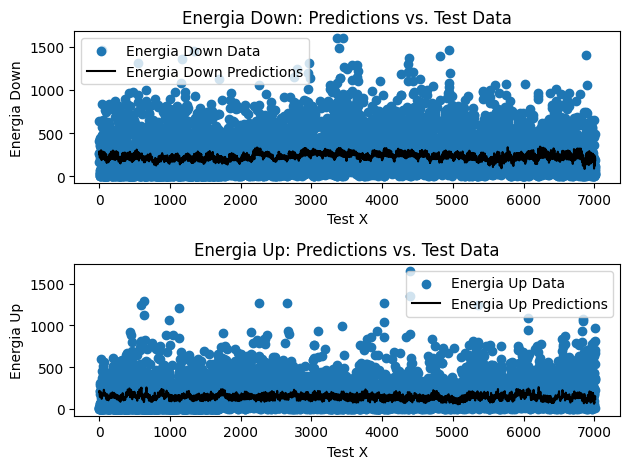

In [32]:
plot_pred_vs_test(np.arange(len(test_dataset_X)), test_dataset_Y.squeeze(), predictions)

In [33]:
def plot_percentage_diffs(predictions, test_dataset_Y):
    mse_dim1 = np.mean((predictions[:, 0] - test_dataset_Y.squeeze()[:,0]) ** 2)
    rmse_dim1 = np.sqrt(mse_dim1)

    mse_dim2 = np.mean((predictions[:, 1] - test_dataset_Y.squeeze()[:,1]) ** 2)
    rmse_dim2 = np.sqrt(mse_dim2)

    mse = np.mean((predictions - test_dataset_Y.squeeze()) ** 2)
    rmse = np.sqrt(mse)

    
    print("The root mean squared erros in Energia down is",rmse_dim1)
    print("The root mean squared erros in Energia up is",rmse_dim2)
    
    print("The root mean squared erros in both is",rmse)
    
    
    differences_dim1_percentage = ((predictions[:, 0]+1.62) - (test_dataset_Y.squeeze()[:,0]+1.62))/test_dataset_Y.squeeze()[:, 0]+1.62
    differences_dim2_percentage = ((predictions[:, 1]+1.62) - (test_dataset_Y.squeeze()[:,0]+1.62))/test_dataset_Y.squeeze()[:, 1]+1.62

    differences_percentage = (predictions+1.62 - test_dataset_Y.squeeze()+1.62)/(predictions+1.62)

    plt.figure(figsize=(10, 6))

    # Plot differences for dimension 1
    plt.subplot(3, 1, 1)
    plt.plot(range(len(differences_dim1_percentage)), differences_dim1_percentage, 'b.')
    plt.xlabel('Row Index')
    plt.ylabel('Difference')
    plt.title('Energia down: Individual Differences percentage')

    # Plot differences for dimension 2
    plt.subplot(3, 1, 2)
    plt.plot(range(len(differences_dim2_percentage)), differences_dim2_percentage, 'g.')
    plt.xlabel('Row Index')
    plt.ylabel('Difference')
    plt.title('Energia up: Individual Differences percentage')
    
    plt.subplot(3, 1, 3)
    plt.plot(range(len(differences_percentage)), differences_percentage, 'g.')
    plt.xlabel('Row Index')
    plt.ylabel('Difference')
    plt.title('Both: Individual Differences percentage')

    plt.tight_layout()
    plt.show()

The root mean squared erros in Energia down is 224.45948301691416
The root mean squared erros in Energia up is 168.45022556742018
The root mean squared erros in both is 198.44084510243238


/tmp/ipykernel_94713/2371528433.py:18: RuntimeWarning: divide by zero encountered in divide
  differences_dim1_percentage = ((predictions[:, 0]+1.62) - (test_dataset_Y.squeeze()[:,0]+1.62))/test_dataset_Y.squeeze()[:, 0]+1.62
/tmp/ipykernel_94713/2371528433.py:19: RuntimeWarning: divide by zero encountered in divide
  differences_dim2_percentage = ((predictions[:, 1]+1.62) - (test_dataset_Y.squeeze()[:,0]+1.62))/test_dataset_Y.squeeze()[:, 1]+1.62


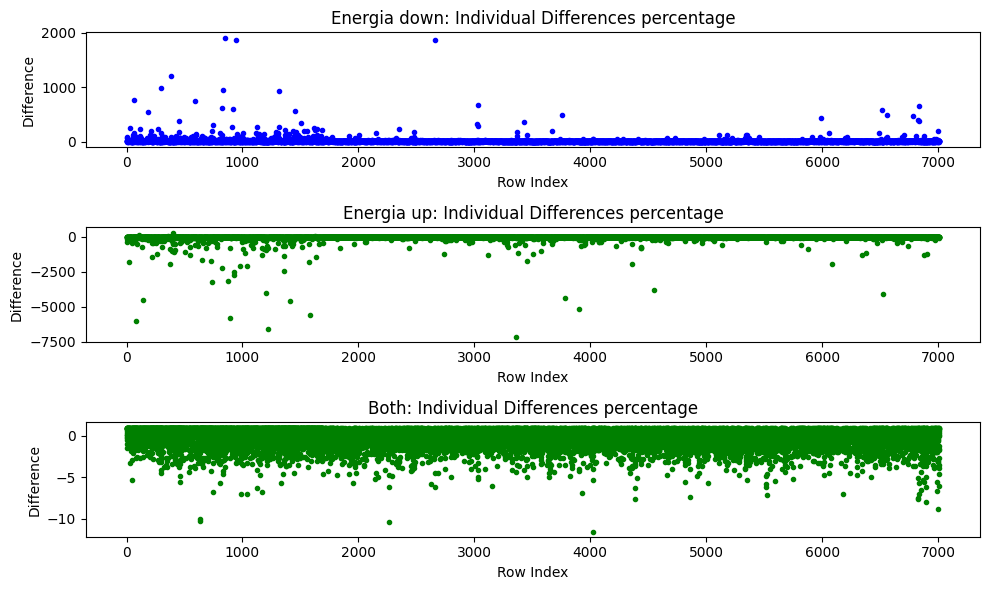

In [34]:
plot_percentage_diffs(predictions, test_dataset_Y)

In [35]:
# Multiple dense layers



input_layer = Input((7,))
normed = Normalization()(input_layer)
normed = Dense(168, activation="linear")(normed)
dropped1 = Dropout(0.5)(normed)

normed = Dense(64, activation="linear")(dropped1)
dropped1 = Dropout(0.5)(normed)

output = Dense(2, activation="linear")(dropped1)

model_dense2 = Model(inputs=input_layer, outputs=output)


In [36]:
model_dense2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7)]               0         
                                                                 
 normalization_1 (Normaliza  (None, 7)                 15        
 tion)                                                           
                                                                 
 dense_1 (Dense)             (None, 168)               1344      
                                                                 
 dropout (Dropout)           (None, 168)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                10816     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                           

In [37]:
model_dense2.compile(optimizer='adam',loss=root_mean_squared_error, metrics=root_mean_squared_error)
model_dense2.fit(train_dataset_X.squeeze(), train_dataset_Y.squeeze(), epochs=17)

Epoch 1/17
877/877 [==============================] - 1s 891us/step - loss: 1469.0134 - root_mean_squared_error: 1468.3232
Epoch 2/17
877/877 [==============================] - 1s 857us/step - loss: 224.2796 - root_mean_squared_error: 224.2394
Epoch 3/17
877/877 [==============================] - 1s 819us/step - loss: 192.9686 - root_mean_squared_error: 192.9482
Epoch 4/17
877/877 [==============================] - 1s 829us/step - loss: 190.4561 - root_mean_squared_error: 190.4549
Epoch 5/17
877/877 [==============================] - 1s 808us/step - loss: 191.0501 - root_mean_squared_error: 191.0215
Epoch 6/17
877/877 [==============================] - 1s 793us/step - loss: 191.2137 - root_mean_squared_error: 191.1853
Epoch 7/17
877/877 [==============================] - 1s 788us/step - loss: 191.2047 - root_mean_squared_error: 191.2125
Epoch 8/17
877/877 [==============================] - 1s 785us/step - loss: 191.6738 - root_mean_squared_error: 191.6886
Epoch 9/17
877/877 [==========

In [38]:
predictions = model_dense2.predict(test_dataset_X.squeeze())

220/220 [==============================] - 0s 659us/step


In [39]:
model_dense2.evaluate(test_dataset_X.squeeze(), test_dataset_Y.squeeze())

220/220 [==============================] - 0s 770us/step - loss: 198.6580 - root_mean_squared_error: 199.2599


[198.6580352783203, 199.25987243652344]

In [40]:
test_dataset["dense2 Energia Down"] = None
test_dataset["dense2 Energia Up"] = None

test_dataset.loc[test_index+X_timeseries, "dense2 Energia Down"] = predictions[:,0]
test_dataset.loc[test_index+X_timeseries, "dense2 Energia Up"] = predictions[:,1]


(7012,)
(7012, 2)


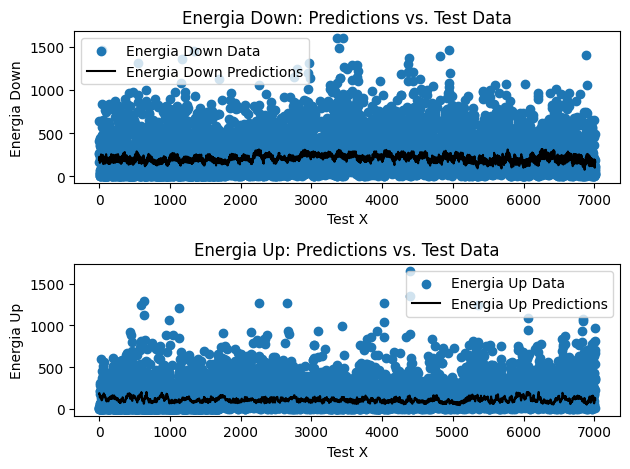

In [41]:
plot_pred_vs_test(np.arange(len(test_dataset_X)), test_dataset_Y.squeeze(), predictions)

The root mean squared erros in Energia down is 228.18342724926651
The root mean squared erros in Energia up is 173.10478177235896
The root mean squared erros in both is 202.52523539509505


/tmp/ipykernel_94713/2371528433.py:18: RuntimeWarning: divide by zero encountered in divide
  differences_dim1_percentage = ((predictions[:, 0]+1.62) - (test_dataset_Y.squeeze()[:,0]+1.62))/test_dataset_Y.squeeze()[:, 0]+1.62
/tmp/ipykernel_94713/2371528433.py:19: RuntimeWarning: divide by zero encountered in divide
  differences_dim2_percentage = ((predictions[:, 1]+1.62) - (test_dataset_Y.squeeze()[:,0]+1.62))/test_dataset_Y.squeeze()[:, 1]+1.62


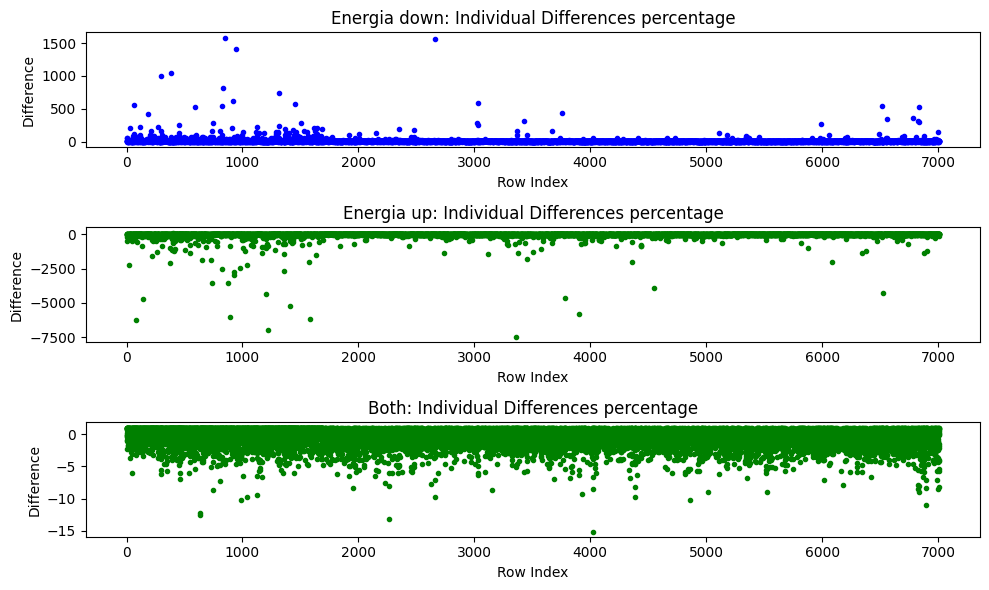

In [42]:
plot_percentage_diffs(predictions, test_dataset_Y)

In [43]:
uri = "model_dense2.keras"
model_dense2.save(uri)


In [44]:
test_dataset[test_dataset["dense2 Energia Down"]==test_dataset["dense2 Energia Down"]]

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
28049         638.9         2.3                  15822.0            62.7   
28050         410.3         0.5                  15684.0             0.0   
28051         269.4        12.7                  15627.0             0.0   
28052         252.8        14.7                  15627.0             0.0   
28053         161.0        21.4                  15427.0             0.0   
...             ...         ...                      ...             ...   
35056         113.2       374.4                  10588.0             0.0   
35057         186.4       816.6                  10615.5             0.0   
35058          35.0       673.5                  10477.8             0.0   
35059          21.1       344.9                  10446.8             0.0   
35060         486.0         3.9                  10402.5             0.0   

       DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
28049              31533.0           35048.3               -4162.2   
28050              32765.0           36029.4               -4060.0   
28051              31676.0           35060.3               -4080.5   
28052              28887.0           32296.1               -4217.2   
28053              26119.0           29388.5               -3884.8   
...                    ...               ...                   ...   
35056              25526.3           24829.1                -496.0   
35057              26203.0           24536.6                 579.2   
35058              25256.5           24128.0                 483.6   
35059              24142.3           20040.7                3398.3   
35060              21761.5           19618.6                1756.2   

       DA Traded Wind  DA Traded PV dense Energia Down dense Energia Up  \
28049         17796.2         169.3         256.814636       206.170029   
28050         17852.7         161.4         279.192474       211.213455   
28051         17468.7         116.0         289.566925       215.599884   
28052         16997.5          37.9         281.428833        207.95575   
28053         16607.7           5.5         263.755646       188.453033   
...               ...           ...                ...              ...   
35056         11444.4         301.1         175.830139       137.081299   
35057         11529.9          58.5         217.246506       142.985107   
35058         11457.4           8.6         218.442291       147.464005   
35059          9346.3           7.2         205.405777       151.241531   
35060          9190.6           6.7         186.158234       118.873024   

      dense2 Energia Down dense2 Energia Up  
28049          191.469315        181.487762  
28050          216.870956        185.737778  
28051           227.21022        188.337708  
28052          220.153183        182.948105  
28053          198.739487        170.089706  
...                   ...               ...  
35056          142.256866        115.378021  
35057          178.601486        124.737686  
35058          184.306152        128.484375  
35059          176.534683        130.734406  
35060          167.820541        106.586617  

[7012 rows x 13 columns]

In [45]:
35064/24 # this is the number of days in the dataset

1461.0

In [46]:
7*24

168

In [47]:
len(dataset)

35062

In [48]:
# One week to get one day

X_timeseries = 168
Y_timeseries = 24

train_dataset_X, train_dataset_Y, test_dataset_X, test_dataset_Y, index_test = get_dataset(dataset, 
                                                                               time_moving_window_size_X=X_timeseries,
                                                                              time_moving_window_size_Y=Y_timeseries,
                                                                              )

In [49]:

end_ind = test_dataset[(test_dataset["Energia Down"]==test_dataset_Y[-1][0][0])&(test_dataset["Energia Up"]==test_dataset_Y[-1][0][1])].index.item()
start_ind = test_dataset[(test_dataset["Energia Down"]==test_dataset_Y[0][0][0])&(test_dataset["Energia Up"]==test_dataset_Y[0][0][1])].index.item()

In [50]:
## Simple timeries conv model



import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import (
    BatchNormalization,
    Normalization,
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling1D,
    concatenate,
)


from keras.models import Model

time_length = X_timeseries #hours

# channels last -> channels sao as dimensoes diff
input_layer_saphe = (time_length, 7)
filters = 128
dropout_value = 0.25
kernel_size = 3
input_layer = Input(input_layer_saphe)
normed = BatchNormalization()(input_layer)





# first feature extractor
conv1 = Conv1D(
    filters=64,
    kernel_size=kernel_size,
    activation="linear",
)(normed)

normed1 = BatchNormalization()(conv1)
dropped1 = Dropout(dropout_value)(normed1)
convd1 = Conv1D(
    filters=filters,
    kernel_size=kernel_size,
    activation="linear",
)(dropped1)
normed11 = BatchNormalization()(convd1)
pool1 = MaxPooling1D(pool_size=2)(normed11)
flat1 = Flatten()(pool1)

min_value_inshape = min([f for f in normed.shape if f is not None])
values_consider = []

for i in range(min_value_inshape):
    step = min_value_inshape - i + 1
    if step >= i:
        values_consider.append(i)

kernel_size_second = max(values_consider)

# second feature extractor
conv2 = Conv1D(
    filters=filters,
    kernel_size=kernel_size_second,
    activation='linear',
)(normed)
normed2 = BatchNormalization()(conv2)

dropped2 = Dropout(dropout_value)(normed2)
convd2 = Conv1D(
    filters=filters,
    kernel_size=kernel_size_second,
    activation="linear",
)(dropped2)
normed22 = BatchNormalization()(convd2)
pool_zi = min([f for f in normed22.shape if f is not None])
pool_zi = min([pool_zi, 2])
pool2 = MaxPooling1D(pool_size=pool_zi)(normed22)
flat2 = Flatten()(pool2)
# merge feature extractors
merge = concatenate([flat1, flat2])
dropped = Dropout(dropout_value)(merge)

# interpretation layer
hidden1 = Dense(100, activation='linear')(dropped)
normed3 = Normalization()(hidden1)
# prediction output
# Reshape output to (24, 2)
output = Dense(24 * 2, activation="linear")(normed3)
reshaped_output = tf.reshape(output, (-1, Y_timeseries, 2))











model = Model(inputs=input_layer, outputs=reshaped_output)


In [51]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 168, 7)]             0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 168, 7)               28        ['input_3[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv1d (Conv1D)             (None, 166, 64)              1408      ['batch_normalization[0][0]'] 
                                                                                                  
 conv1d_2 (Conv1D)           (None, 165, 128)             3712      ['batch_normalization[0]

In [52]:
model.compile(optimizer='adam',loss=root_mean_squared_error, metrics=root_mean_squared_error)

In [53]:
model.fit(train_dataset_X, train_dataset_Y, epochs=10)

Epoch 1/10
872/872 [==============================] - 37s 41ms/step - loss: 184.2596 - root_mean_squared_error: 184.2561
Epoch 2/10
872/872 [==============================] - 36s 41ms/step - loss: 181.9975 - root_mean_squared_error: 181.9926
Epoch 3/10
872/872 [==============================] - 34s 38ms/step - loss: 181.2359 - root_mean_squared_error: 181.2358
Epoch 4/10
872/872 [==============================] - 33s 38ms/step - loss: 180.7402 - root_mean_squared_error: 180.7447
Epoch 5/10
872/872 [==============================] - 33s 38ms/step - loss: 180.3577 - root_mean_squared_error: 180.3609
Epoch 6/10
872/872 [==============================] - 35s 40ms/step - loss: 180.0222 - root_mean_squared_error: 180.0235
Epoch 7/10
872/872 [==============================] - 36s 41ms/step - loss: 179.6969 - root_mean_squared_error: 179.6994
Epoch 8/10
872/872 [==============================] - 36s 41ms/step - loss: 179.3618 - root_mean_squared_error: 179.3607
Epoch 9/10
872/872 [============

In [54]:
uri = "model_conv1D.keras"
model.save(uri)


In [55]:
model.history.history

{'loss': [184.2596435546875,
  181.99746704101562,
  181.23594665527344,
  180.74024963378906,
  180.3577423095703,
  180.02223205566406,
  179.69691467285156,
  179.36178588867188,
  179.03814697265625,
  178.7119598388672],
 'root_mean_squared_error': [184.2560577392578,
  181.9926300048828,
  181.23577880859375,
  180.74472045898438,
  180.36093139648438,
  180.02346801757812,
  179.69944763183594,
  179.36068725585938,
  179.0395050048828,
  178.71197509765625]}

In [56]:
predictions = model.predict(test_dataset_X)

218/218 [==============================] - 2s 8ms/step


In [57]:
predictions.shape

(6974, 24, 2)

In [58]:
def moving_mean_predictions(predictions):
    flatten_preds = []
    size = len(predictions)


    for i in range(size):
        row = predictions[i]
        init = np.full((i, 2), np.nan)
        end_len = size - i
        if end_len<0:
            end = np.full((0, 2), np.nan)
        else:
            end = np.full((end_len, 2), np.nan)
        fi_row = np.concatenate([init, row, end])
        flatten_preds.append(fi_row)
    flatten_preds = np.array(flatten_preds)
    moving_mean = np.nanmean(flatten_preds, axis=0)
    mask = np.isnan(moving_mean).any(axis=1)
    return moving_mean[~mask]

In [59]:
predictions_mean = moving_mean_predictions(predictions)
test_dataset_Y_mean = moving_mean_predictions(test_dataset_Y)

/tmp/ipykernel_94713/2155408381.py:17: RuntimeWarning: Mean of empty slice
  moving_mean = np.nanmean(flatten_preds, axis=0)


In [60]:
test_dataset[(test_dataset["Energia Down"]==test_dataset_Y[-1][0][0])&(test_dataset["Energia Up"]==test_dataset_Y[-1][0][1])]

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
35037         171.3       189.2                  12227.8             0.0   

       DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
35037              23231.8           20143.0                2156.9   

       DA Traded Wind  DA Traded PV dense Energia Down dense Energia Up  \
35037         10727.4           6.4         199.882431       144.072464   

      dense2 Energia Down dense2 Energia Up  
35037          165.248352        130.118622

In [61]:

end_ind = test_dataset[(test_dataset["Energia Down"]==test_dataset_Y[-1][0][0])&(test_dataset["Energia Up"]==test_dataset_Y[-1][0][1])].index.item()
start_ind = test_dataset[(test_dataset["Energia Down"]==test_dataset_Y[0][0][0])&(test_dataset["Energia Up"]==test_dataset_Y[0][0][1])].index.item()

In [62]:
test_dataset.loc[start_ind:end_ind]

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
28064         350.2         0.9                  12454.0          3746.7   
28065          68.9        64.9                  12250.0          4142.5   
28066          42.9       304.8                  12326.0          3994.0   
28067           7.7       213.1                  12536.0          3651.4   
28068         149.7        11.1                  12697.0          3561.4   
...             ...         ...                      ...             ...   
35033         168.7       124.6                  12373.0             0.0   
35034          61.9       420.4                  12439.0             0.0   
35035         196.0       155.9                  12511.5             0.0   
35036         208.8        89.7                  12414.5             0.0   
35037         171.3       189.2                  12227.8             0.0   

       DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
28064              31585.0           35757.5               -4621.0   
28065              31480.0           35473.3               -4516.4   
28066              31437.0           36056.6               -4894.0   
28067              31310.0           35732.6               -4823.0   
28068              30674.0           35384.6               -4986.8   
...                    ...               ...                   ...   
35033              27807.8           27419.3               -1378.1   
35034              27454.0           25734.6                 566.8   
35035              27231.3           23528.4                2497.7   
35036              25260.5           22203.3                2148.9   
35037              23231.8           20143.0                2156.9   

       DA Traded Wind  DA Traded PV dense Energia Down dense Energia Up  \
28064         12952.7        4489.9         266.422821       193.154541   
28065         12946.1        5268.4         268.104492       193.697098   
28066         12918.2        5657.2         258.110596       198.195862   
28067         13178.8        5817.5         247.025223       204.146103   
28068         13263.7        5583.5         237.763931        205.92691   
...               ...           ...                ...              ...   
35033         13815.6         230.0          248.96022       150.402237   
35034         13648.1           8.1         247.887665       157.584793   
35035         13190.7           6.8         227.665314       163.827148   
35036         12424.9           6.5         215.344772       156.733261   
35037         10727.4           6.4         199.882431       144.072464   

      dense2 Energia Down dense2 Energia Up  
28064          218.370483        158.047272  
28065          214.494583        155.574188  
28066          203.567215         156.33194  
28067          195.910995        158.561493  
28068          185.855148        159.134247  
...                   ...               ...  
35033          190.709763        134.712189  
35034          191.793839        140.422821  
35035          184.889542        144.766632  
35036          177.804611        139.490509  
35037          165.248352        130.118622  

[6974 rows x 13 columns]

In [63]:
len(test_dataset_Y)

6974

In [64]:
len(test_dataset_Y_mean)

6997

In [65]:
test_index = test_dataset.loc[start_ind:35060].index

In [66]:
test_dataset.loc[28064:35060]

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
28064         350.2         0.9                  12454.0          3746.7   
28065          68.9        64.9                  12250.0          4142.5   
28066          42.9       304.8                  12326.0          3994.0   
28067           7.7       213.1                  12536.0          3651.4   
28068         149.7        11.1                  12697.0          3561.4   
...             ...         ...                      ...             ...   
35056         113.2       374.4                  10588.0             0.0   
35057         186.4       816.6                  10615.5             0.0   
35058          35.0       673.5                  10477.8             0.0   
35059          21.1       344.9                  10446.8             0.0   
35060         486.0         3.9                  10402.5             0.0   

       DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
28064              31585.0           35757.5               -4621.0   
28065              31480.0           35473.3               -4516.4   
28066              31437.0           36056.6               -4894.0   
28067              31310.0           35732.6               -4823.0   
28068              30674.0           35384.6               -4986.8   
...                    ...               ...                   ...   
35056              25526.3           24829.1                -496.0   
35057              26203.0           24536.6                 579.2   
35058              25256.5           24128.0                 483.6   
35059              24142.3           20040.7                3398.3   
35060              21761.5           19618.6                1756.2   

       DA Traded Wind  DA Traded PV dense Energia Down dense Energia Up  \
28064         12952.7        4489.9         266.422821       193.154541   
28065         12946.1        5268.4         268.104492       193.697098   
28066         12918.2        5657.2         258.110596       198.195862   
28067         13178.8        5817.5         247.025223       204.146103   
28068         13263.7        5583.5         237.763931        205.92691   
...               ...           ...                ...              ...   
35056         11444.4         301.1         175.830139       137.081299   
35057         11529.9          58.5         217.246506       142.985107   
35058         11457.4           8.6         218.442291       147.464005   
35059          9346.3           7.2         205.405777       151.241531   
35060          9190.6           6.7         186.158234       118.873024   

      dense2 Energia Down dense2 Energia Up  
28064          218.370483        158.047272  
28065          214.494583        155.574188  
28066          203.567215         156.33194  
28067          195.910995        158.561493  
28068          185.855148        159.134247  
...                   ...               ...  
35056          142.256866        115.378021  
35057          178.601486        124.737686  
35058          184.306152        128.484375  
35059          176.534683        130.734406  
35060          167.820541        106.586617  

[6997 rows x 13 columns]

In [67]:
test_dataset_Y_mean.shape

(6997, 2)

In [68]:
test_dataset

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
0              83.7       116.9                   3715.0             0.0   
1              11.6       348.1                   3748.0             0.0   
2              15.3       286.9                   3545.0             0.0   
3              36.6       398.4                   3407.0             0.0   
4              22.4       280.9                   3321.0             0.0   
...             ...         ...                      ...             ...   
35057         186.4       816.6                  10615.5             0.0   
35058          35.0       673.5                  10477.8             0.0   
35059          21.1       344.9                  10446.8             0.0   
35060         486.0         3.9                  10402.5             0.0   
35061         352.4        15.9                  10305.0             0.0   

       DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
0                  21808.0           18365.7                1524.9   
1                  20635.0           17396.3                1336.4   
2                  19824.0           17080.8                1158.3   
3                  19544.0           17125.4                1114.3   
4                  19803.0           17163.7                1323.6   
...                    ...               ...                   ...   
35057              26203.0           24536.6                 579.2   
35058              25256.5           24128.0                 483.6   
35059              24142.3           20040.7                3398.3   
35060              21761.5           19618.6                1756.2   
35061              20590.3           16847.4                3270.8   

       DA Traded Wind  DA Traded PV dense Energia Down dense Energia Up  \
0              4326.8           7.1               None             None   
1              4213.9           7.1               None             None   
2              4059.7           7.1               None             None   
3              3921.6           7.1               None             None   
4              3902.3          14.1               None             None   
...               ...           ...                ...              ...   
35057         11529.9          58.5         217.246506       142.985107   
35058         11457.4           8.6         218.442291       147.464005   
35059          9346.3           7.2         205.405777       151.241531   
35060          9190.6           6.7         186.158234       118.873024   
35061          8314.2           6.6               None             None   

      dense2 Energia Down dense2 Energia Up  
0                    None              None  
1                    None              None  
2                    None              None  
3                    None              None  
4                    None              None  
...                   ...               ...  
35057          178.601486        124.737686  
35058          184.306152        128.484375  
35059          176.534683        130.734406  
35060          167.820541        106.586617  
35061                None              None  

[35062 rows x 13 columns]

In [69]:
Y_timeseries

24

In [70]:
test_dataset_Y_mean

array([[350.2,   0.9],
       [ 68.9,  64.9],
       [ 42.9, 304.8],
       ...,
       [ 35. , 673.5],
       [ 21.1, 344.9],
       [486. ,   3.9]])

In [71]:
test_dataset_Y_mean[-4]

array([186.4, 816.6])

In [72]:
test_dataset_Y_mean

array([[350.2,   0.9],
       [ 68.9,  64.9],
       [ 42.9, 304.8],
       ...,
       [ 35. , 673.5],
       [ 21.1, 344.9],
       [486. ,   3.9]])

In [73]:
test_dataset.loc[35037]

Energia Down                    171.3
Energia Up                      189.2
Day-ahead Forecast Wind       12227.8
DA Forecast PV                    0.0
DA Forecast Consumo           23231.8
DAToda a Geração              20143.0
DA Tie Lines Balance           2156.9
DA Traded Wind                10727.4
DA Traded PV                      6.4
dense Energia Down         199.882431
dense Energia Up           144.072464
dense2 Energia Down        165.248352
dense2 Energia Up          130.118622
Name: 35037, dtype: object

In [74]:
test_index

Index([28064, 28065, 28066, 28067, 28068, 28069, 28070, 28071, 28072, 28073,
       ...
       35051, 35052, 35053, 35054, 35055, 35056, 35057, 35058, 35059, 35060],
      dtype='int64', length=6997)

In [75]:
len(test_index)

6997

In [76]:
len(predictions_mean)

6997

In [77]:
test_dataset["conv Energia Down"] = None
test_dataset["conv Energia Up"] = None

test_dataset.loc[test_index, "conv Energia Down"] = predictions_mean[:,0]
test_dataset.loc[test_index, "conv Energia Up"] = predictions_mean[:,1]


In [78]:
test_dataset

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
0              83.7       116.9                   3715.0             0.0   
1              11.6       348.1                   3748.0             0.0   
2              15.3       286.9                   3545.0             0.0   
3              36.6       398.4                   3407.0             0.0   
4              22.4       280.9                   3321.0             0.0   
...             ...         ...                      ...             ...   
35057         186.4       816.6                  10615.5             0.0   
35058          35.0       673.5                  10477.8             0.0   
35059          21.1       344.9                  10446.8             0.0   
35060         486.0         3.9                  10402.5             0.0   
35061         352.4        15.9                  10305.0             0.0   

       DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
0                  21808.0           18365.7                1524.9   
1                  20635.0           17396.3                1336.4   
2                  19824.0           17080.8                1158.3   
3                  19544.0           17125.4                1114.3   
4                  19803.0           17163.7                1323.6   
...                    ...               ...                   ...   
35057              26203.0           24536.6                 579.2   
35058              25256.5           24128.0                 483.6   
35059              24142.3           20040.7                3398.3   
35060              21761.5           19618.6                1756.2   
35061              20590.3           16847.4                3270.8   

       DA Traded Wind  DA Traded PV dense Energia Down dense Energia Up  \
0              4326.8           7.1               None             None   
1              4213.9           7.1               None             None   
2              4059.7           7.1               None             None   
3              3921.6           7.1               None             None   
4              3902.3          14.1               None             None   
...               ...           ...                ...              ...   
35057         11529.9          58.5         217.246506       142.985107   
35058         11457.4           8.6         218.442291       147.464005   
35059          9346.3           7.2         205.405777       151.241531   
35060          9190.6           6.7         186.158234       118.873024   
35061          8314.2           6.6               None             None   

      dense2 Energia Down dense2 Energia Up conv Energia Down conv Energia Up  
0                    None              None              None            None  
1                    None              None              None            None  
2                    None              None              None            None  
3                    None              None              None            None  
4                    None              None              None            None  
...                   ...               ...               ...             ...  
35057          178.601486        124.737686        294.204834        78.68259  
35058          184.306152        128.484375           213.717      139.970675  
35059          176.534683        130.734406        143.996155      182.707764  
35060          167.820541        106.586617        136.144638      187.702682  
35061                None              None              None            None  

[35062 rows x 15 columns]

(6997,)
(6997, 2)


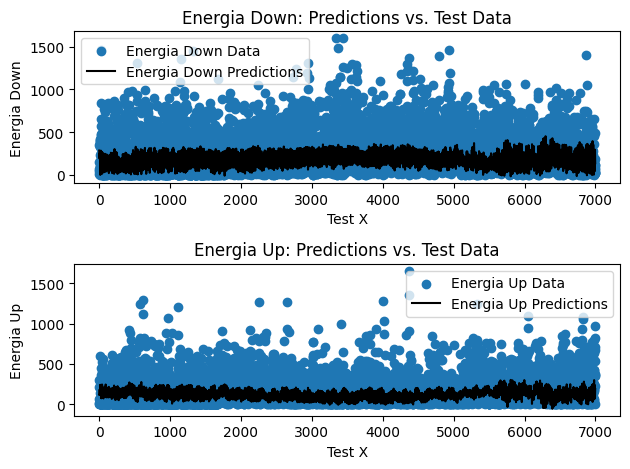

In [79]:
plot_pred_vs_test(np.arange(len(test_dataset_Y_mean)), test_dataset_Y_mean.squeeze(), predictions_mean)

The root mean squared erros in Energia down is 230.17127562387918
The root mean squared erros in Energia up is 172.82045223366842
The root mean squared erros in both is 203.52607306260964


/tmp/ipykernel_94713/2371528433.py:18: RuntimeWarning: divide by zero encountered in divide
  differences_dim1_percentage = ((predictions[:, 0]+1.62) - (test_dataset_Y.squeeze()[:,0]+1.62))/test_dataset_Y.squeeze()[:, 0]+1.62
/tmp/ipykernel_94713/2371528433.py:19: RuntimeWarning: divide by zero encountered in divide
  differences_dim2_percentage = ((predictions[:, 1]+1.62) - (test_dataset_Y.squeeze()[:,0]+1.62))/test_dataset_Y.squeeze()[:, 1]+1.62


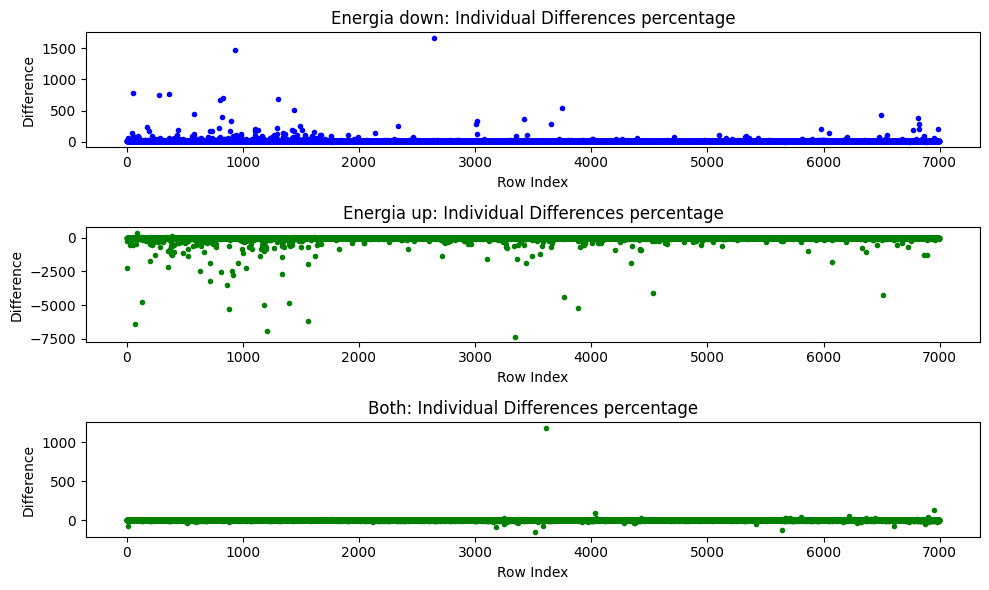

In [80]:
plot_percentage_diffs(predictions_mean, test_dataset_Y_mean)

In [81]:

end_ind = test_dataset[(test_dataset["Day-ahead Forecast Wind"]==test_dataset_X[-1][0][0])&(test_dataset["DA Tie Lines Balance"]==test_dataset_X[-1][0][4])].index.item()
start_ind = test_dataset[(test_dataset["Day-ahead Forecast Wind"]==test_dataset_X[0][0][0])&(test_dataset["DA Tie Lines Balance"]==test_dataset_X[0][0][4])].index.item()

In [82]:
test_dataset[start_ind:end_ind]

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
27896          14.5       248.7                   7692.0          4386.2   
27897           7.6       166.5                   7840.0          5844.9   
27898         184.1       119.8                   7952.0          6104.9   
27899         255.6        23.7                   7452.0          6489.8   
27900         660.3        28.3                   6970.0          6658.4   
...             ...         ...                      ...             ...   
34864         259.6        21.6                   9666.0             0.0   
34865         459.1        13.7                   9659.5             0.0   
34866         201.0       138.8                   9580.0             0.0   
34867         129.1       252.9                   9319.5             0.0   
34868         145.4       170.7                   8859.3             0.0   

       DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
27896              32953.0           30026.5                 428.7   
27897              32683.0           30367.9                 719.7   
27898              32619.0           31092.3                 303.8   
27899              32528.0           30749.7                1068.9   
27900              32104.0           30222.8                1035.1   
...                    ...               ...                   ...   
34864              29885.3           29403.9               -2045.4   
34865              30105.0           29508.3               -1836.7   
34866              30311.8           29226.4               -1633.0   
34867              29684.5           28853.1               -1915.8   
34868              27261.0           27070.1               -2097.3   

       DA Traded Wind  DA Traded PV dense Energia Down dense Energia Up  \
27896          7923.6        4667.3               None             None   
27897          7839.4        5978.9               None             None   
27898          7785.6        6647.4               None             None   
27899          7516.2        6827.2               None             None   
27900          7379.4        6869.1               None             None   
...               ...           ...                ...              ...   
34864         10821.4          71.6         253.464584       143.133713   
34865         10689.8          38.7         289.276001       132.974716   
34866         10388.5          36.9         289.616791       133.459702   
34867         10327.0           7.5         295.276184       126.022102   
34868         10086.4           7.1         292.202332       124.353867   

      dense2 Energia Down dense2 Energia Up conv Energia Down conv Energia Up  
27896                None              None              None            None  
27897                None              None              None            None  
27898                None              None              None            None  
27899                None              None              None            None  
27900                None              None              None            None  
...                   ...               ...               ...             ...  
34864          203.827194        120.017487         344.01849         -3.4727  
34865          235.462112        117.198036        358.113088        8.061751  
34866          238.084122         117.38018        265.076491        88.53826  
34867          241.427185        112.087364        175.997903      142.731273  
34868          237.326797        110.712715        158.056089      140.966523  

[6973 rows x 15 columns]

In [83]:
# RNN try

from tensorflow.keras.layers import (
    LSTM,
    BatchNormalization,
    Bidirectional,
    Dense,
    Dropout,
    MaxPooling1D,
)

# channels last -> channels sao as dimensoes diff
input_layer_saphe = (time_length, 7)
filters = 128
dropout_value = 0.25
kernel_size = 3
input_layer = Input(input_layer_saphe)
normed = BatchNormalization()(input_layer)


lstm_units = (120, 80)
pool_size = 3


x = BatchNormalization()(normed)
x = LSTM(
    lstm_units[0],
    return_sequences=True,
    dropout=dropout_value,
    recurrent_dropout=dropout_value,
)(x)
x = MaxPooling1D(pool_size=pool_size)(x)
x = BatchNormalization()(x)
x = Bidirectional(
    LSTM(
        lstm_units[1],
        dropout=dropout_value,
        recurrent_dropout=dropout_value,
    )
)(x)
x = BatchNormalization()(x)
x = Dropout(dropout_value)(x)
x = Dense(120, activation="linear")(x)
x = BatchNormalization()(x)
x = Dense(24 * 2, activation="linear")(x)
x = tf.reshape(x, (-1, 24, 2))


model_rnn = Model(inputs=input_layer, outputs=x)


In [84]:
model_rnn.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 168, 7)]          0         
                                                                 
 batch_normalization_5 (Bat  (None, 168, 7)            28        
 chNormalization)                                                
                                                                 
 batch_normalization_6 (Bat  (None, 168, 7)            28        
 chNormalization)                                                
                                                                 
 lstm (LSTM)                 (None, 168, 120)          61440     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 56, 120)           0         
 g1D)                                                            
                                                           

In [85]:
model_rnn.compile(optimizer='adam',loss=root_mean_squared_error, metrics=root_mean_squared_error)

In [86]:
model_rnn.fit(train_dataset_X, train_dataset_Y, epochs=5)

Epoch 1/5
872/872 [==============================] - 107s 118ms/step - loss: 223.5641 - root_mean_squared_error: 223.5517
Epoch 2/5
872/872 [==============================] - 107s 122ms/step - loss: 184.3212 - root_mean_squared_error: 184.3214
Epoch 3/5
872/872 [==============================] - 102s 117ms/step - loss: 180.4744 - root_mean_squared_error: 180.4746
Epoch 4/5
872/872 [==============================] - 111s 127ms/step - loss: 177.5434 - root_mean_squared_error: 177.5423
Epoch 5/5
872/872 [==============================] - 99s 114ms/step - loss: 175.6248 - root_mean_squared_error: 175.6260


In [87]:
uri = "model_rnn.keras"
model_rnn.save(uri)


In [88]:
predictions = model_rnn.predict(test_dataset_X)

218/218 [==============================] - 6s 24ms/step


In [89]:
predictions_mean = moving_mean_predictions(predictions)
test_dataset_Y_mean = moving_mean_predictions(test_dataset_Y)

/tmp/ipykernel_94713/2155408381.py:17: RuntimeWarning: Mean of empty slice
  moving_mean = np.nanmean(flatten_preds, axis=0)


In [90]:
test_dataset["rnn Energia Down"] = None
test_dataset["rnn Energia Up"] = None

test_dataset.loc[test_index, "rnn Energia Down"] = predictions_mean[:,0]
test_dataset.loc[test_index, "rnn Energia Up"] = predictions_mean[:,1]


In [91]:
test_dataset

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
0              83.7       116.9                   3715.0             0.0   
1              11.6       348.1                   3748.0             0.0   
2              15.3       286.9                   3545.0             0.0   
3              36.6       398.4                   3407.0             0.0   
4              22.4       280.9                   3321.0             0.0   
...             ...         ...                      ...             ...   
35057         186.4       816.6                  10615.5             0.0   
35058          35.0       673.5                  10477.8             0.0   
35059          21.1       344.9                  10446.8             0.0   
35060         486.0         3.9                  10402.5             0.0   
35061         352.4        15.9                  10305.0             0.0   

       DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
0                  21808.0           18365.7                1524.9   
1                  20635.0           17396.3                1336.4   
2                  19824.0           17080.8                1158.3   
3                  19544.0           17125.4                1114.3   
4                  19803.0           17163.7                1323.6   
...                    ...               ...                   ...   
35057              26203.0           24536.6                 579.2   
35058              25256.5           24128.0                 483.6   
35059              24142.3           20040.7                3398.3   
35060              21761.5           19618.6                1756.2   
35061              20590.3           16847.4                3270.8   

       DA Traded Wind  DA Traded PV dense Energia Down dense Energia Up  \
0              4326.8           7.1               None             None   
1              4213.9           7.1               None             None   
2              4059.7           7.1               None             None   
3              3921.6           7.1               None             None   
4              3902.3          14.1               None             None   
...               ...           ...                ...              ...   
35057         11529.9          58.5         217.246506       142.985107   
35058         11457.4           8.6         218.442291       147.464005   
35059          9346.3           7.2         205.405777       151.241531   
35060          9190.6           6.7         186.158234       118.873024   
35061          8314.2           6.6               None             None   

      dense2 Energia Down dense2 Energia Up conv Energia Down conv Energia Up  \
0                    None              None              None            None   
1                    None              None              None            None   
2                    None              None              None            None   
3                    None              None              None            None   
4                    None              None              None            None   
...                   ...               ...               ...             ...   
35057          178.601486        124.737686        294.204834        78.68259   
35058          184.306152        128.484375           213.717      139.970675   
35059          176.534683        130.734406        143.996155      182.707764   
35060          167.820541        106.586617        136.144638      187.702682   
35061                None              None              None            None   

      rnn Energia Down rnn Energia Up  
0                 None           None  
1                 None           None  
2                 None           None  
3                 None           None  
4                 None           None  
...                ...            ...  
35057       191.552238     161.131042  
35058       208.832845       147.7385  
35059       221.354

(6997,)
(6997, 2)


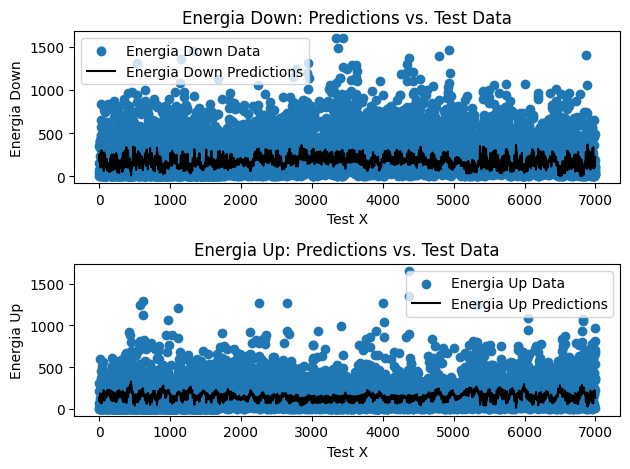

In [92]:
plot_pred_vs_test(np.arange(len(test_dataset_Y_mean)), test_dataset_Y_mean.squeeze(), predictions_mean)

The root mean squared erros in Energia down is 234.24712165864946
The root mean squared erros in Energia up is 169.31299926071037
The root mean squared erros in both is 204.37539690973009


/tmp/ipykernel_94713/2371528433.py:18: RuntimeWarning: divide by zero encountered in divide
  differences_dim1_percentage = ((predictions[:, 0]+1.62) - (test_dataset_Y.squeeze()[:,0]+1.62))/test_dataset_Y.squeeze()[:, 0]+1.62
/tmp/ipykernel_94713/2371528433.py:19: RuntimeWarning: divide by zero encountered in divide
  differences_dim2_percentage = ((predictions[:, 1]+1.62) - (test_dataset_Y.squeeze()[:,0]+1.62))/test_dataset_Y.squeeze()[:, 1]+1.62


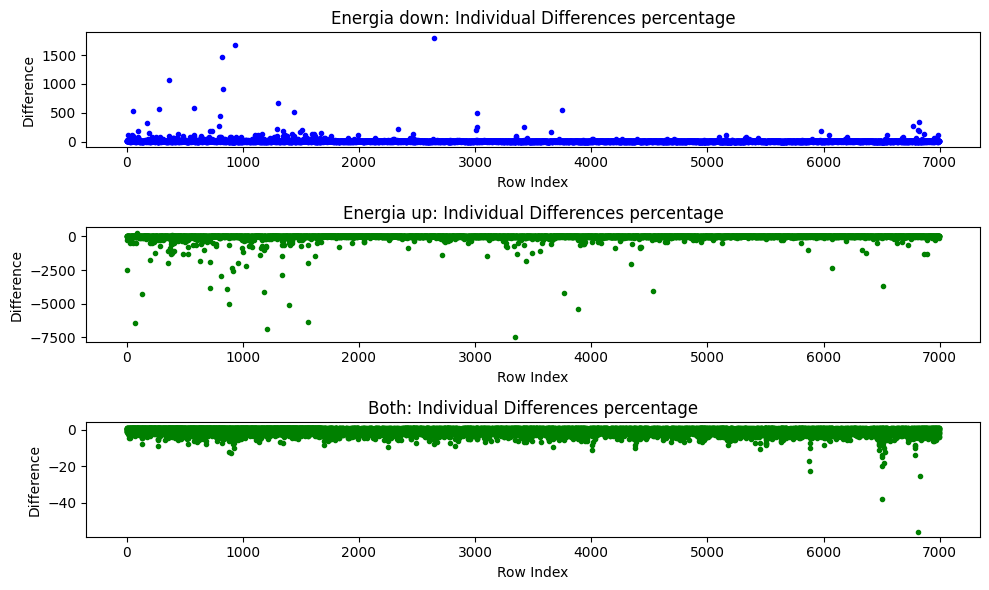

In [93]:
plot_percentage_diffs(predictions_mean, test_dataset_Y_mean)

In [94]:
# Simple CNN
import tensorflow as tf
from keras.models import Model

from tensorflow.keras.layers import (
    LSTM,
    BatchNormalization,
    Bidirectional,
    Dense,
    Dropout,
    MaxPooling1D,Conv1D,Conv2D
)
from tensorflow.keras.layers import Input
pool_size = 3

time_length=168
# channels last -> channels sao as dimensoes diff
input_layer_saphe = (time_length, 7)
filters = 128
dropout_value = 0.25
kernel_size = 3
input_layer = Input(input_layer_saphe)
normed = BatchNormalization()(input_layer)

x = Conv1D(filters=filters, kernel_size=kernel_size, activation='linear')(normed)
x = BatchNormalization()(x)

x = MaxPooling1D(pool_size=pool_size)(x)
x = Conv1D(26, kernel_size=kernel_size, data_format="channels_first")(x)
x = Conv1D(2, kernel_size=kernel_size,data_format="channels_last")(x)

# x = Dense(100, activation="linear")(x)
# x = Dense(24 * 2, activation="linear")(x)
# x = tf.reshape(x, (-1, 24, 2))


model_cnn = Model(inputs=input_layer, outputs=x)


In [95]:
model_cnn.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 168, 7)]          0         
                                                                 
 batch_normalization_10 (Ba  (None, 168, 7)            28        
 tchNormalization)                                               
                                                                 
 conv1d_4 (Conv1D)           (None, 166, 128)          2816      
                                                                 
 batch_normalization_11 (Ba  (None, 166, 128)          512       
 tchNormalization)                                               
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 55, 128)           0         
 g1D)                                                            
                                                           

In [96]:
model_cnn.compile(optimizer='adam',loss=root_mean_squared_error, metrics=root_mean_squared_error)
model_cnn.fit(train_dataset_X, train_dataset_Y, epochs=10)
uri = "model_cnn.keras"
model_cnn.save(uri)


Epoch 1/10
872/872 [==============================] - 6s 6ms/step - loss: 188.8026 - root_mean_squared_error: 188.7990
Epoch 2/10
872/872 [==============================] - 6s 7ms/step - loss: 182.5115 - root_mean_squared_error: 182.5132
Epoch 3/10
872/872 [==============================] - 6s 7ms/step - loss: 181.9987 - root_mean_squared_error: 181.9988
Epoch 4/10
872/872 [==============================] - 6s 7ms/step - loss: 181.6719 - root_mean_squared_error: 181.6736
Epoch 5/10
872/872 [==============================] - 6s 7ms/step - loss: 181.4483 - root_mean_squared_error: 181.4486
Epoch 6/10
872/872 [==============================] - 6s 7ms/step - loss: 181.2147 - root_mean_squared_error: 181.2161
Epoch 7/10
872/872 [==============================] - 6s 7ms/step - loss: 181.0292 - root_mean_squared_error: 181.0335
Epoch 8/10
872/872 [==============================] - 6s 7ms/step - loss: 180.8655 - root_mean_squared_error: 180.8647
Epoch 9/10
872/872 [============================

In [97]:
predictions = model_rnn.predict(test_dataset_X)
predictions_mean = moving_mean_predictions(predictions)
test_dataset_Y_mean = moving_mean_predictions(test_dataset_Y)

218/218 [==============================] - 6s 27ms/step


/tmp/ipykernel_94713/2155408381.py:17: RuntimeWarning: Mean of empty slice
  moving_mean = np.nanmean(flatten_preds, axis=0)


In [98]:
test_dataset["cnn Energia Down"] = None
test_dataset["cnn Energia Up"] = None

test_dataset.loc[test_index, "cnn Energia Down"] = predictions_mean[:,0]
test_dataset.loc[test_index, "cnn Energia Up"] = predictions_mean[:,1]


(6997,)
(6997, 2)


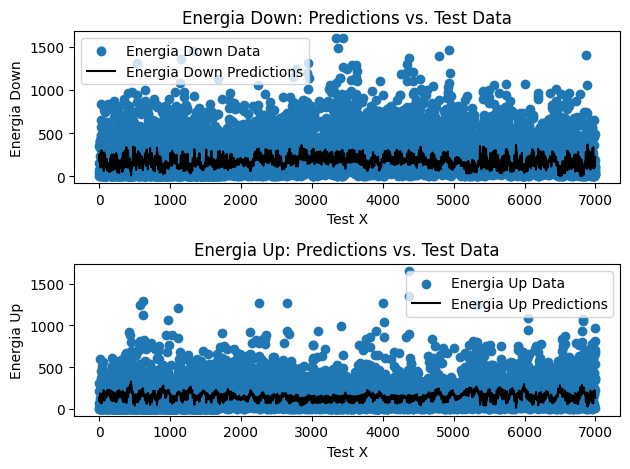

In [99]:
plot_pred_vs_test(np.arange(len(test_dataset_Y_mean)), test_dataset_Y_mean.squeeze(), predictions_mean)

The root mean squared erros in Energia down is 234.24712165864946
The root mean squared erros in Energia up is 169.31299926071037
The root mean squared erros in both is 204.37539690973009


/tmp/ipykernel_94713/2371528433.py:18: RuntimeWarning: divide by zero encountered in divide
  differences_dim1_percentage = ((predictions[:, 0]+1.62) - (test_dataset_Y.squeeze()[:,0]+1.62))/test_dataset_Y.squeeze()[:, 0]+1.62
/tmp/ipykernel_94713/2371528433.py:19: RuntimeWarning: divide by zero encountered in divide
  differences_dim2_percentage = ((predictions[:, 1]+1.62) - (test_dataset_Y.squeeze()[:,0]+1.62))/test_dataset_Y.squeeze()[:, 1]+1.62


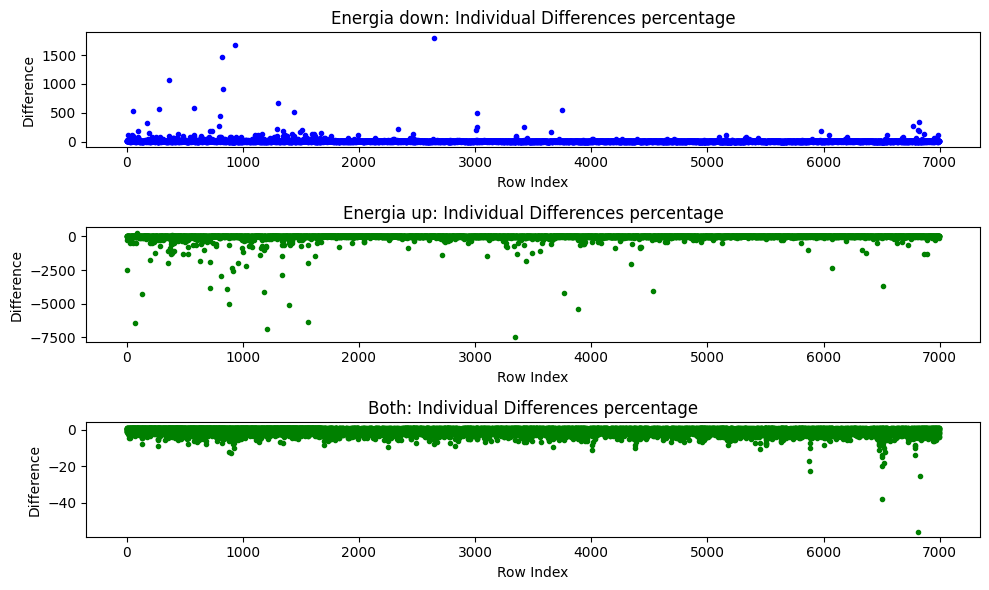

In [100]:
plot_percentage_diffs(predictions_mean, test_dataset_Y_mean)

In [101]:
down_cols = [f for f in test_dataset.columns if "Energia Down" in f]
up_cols = [f for f in test_dataset.columns if "Energia Up" in f]

down_dataset = test_dataset[down_cols].dropna().copy()
up_dataset = test_dataset[up_cols].dropna().copy()

<Axes: >

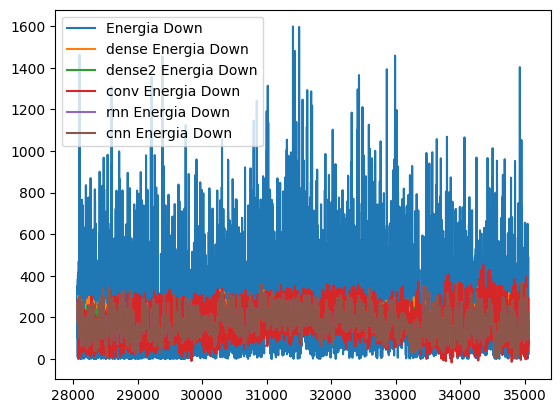

In [102]:
down_dataset.plot()

<Axes: >

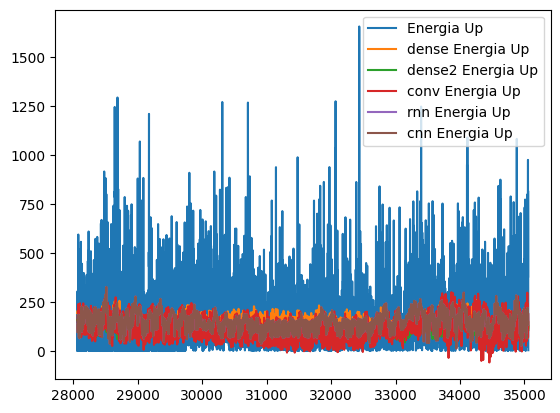

In [103]:
up_dataset.dropna().plot()

In [104]:

cols_use = [f for f in up_dataset.columns if f != "Energia Up"]

for i in cols_use:
    new_name = f"{i} error"
    up_dataset[new_name] = ((up_dataset["Energia Up"]+1.99) - (up_dataset[i]+1.99))/(1.99+up_dataset["Energia Up"])
    
cols_use = [f for f in down_dataset.columns if f != "Energia Down"]

for i in cols_use:
    new_name = f"{i} error"
    down_dataset[new_name] = ((down_dataset["Energia Down"]+1.99) - (down_dataset[i]+1.99))/(1.99+down_dataset["Energia Down"])

In [105]:
up_cols_erro = [f for f in up_dataset.columns if "erro" in f]
down_cols_erro = [f for f in down_dataset.columns if "erro" in f]


<Axes: >

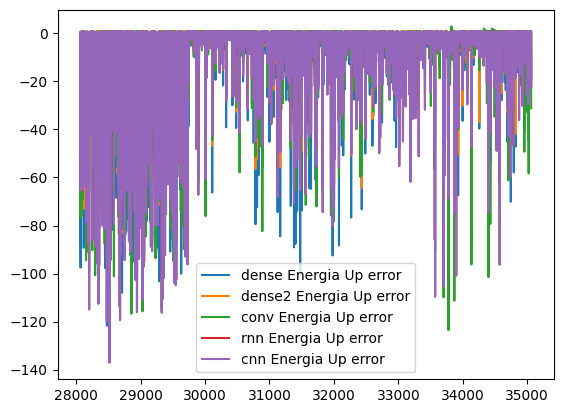

In [106]:
up_dataset[up_cols_erro].plot()

<Axes: >

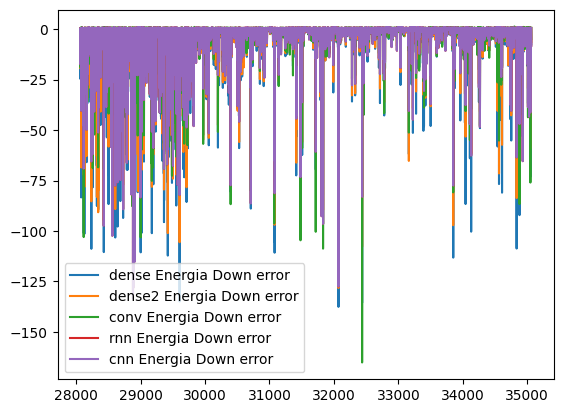

In [107]:
down_dataset[down_cols_erro].plot()